In [195]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
from keras.metrics import MeanSquaredError, MeanAbsoluteError

In [141]:
df = pd.read_csv('Downloads/user_rating.csv')
df.head()

,User_id,Title,Rating
0,111,Udang tumis cabe ijo,5.0
1,112,Ayam goreng tepung saos petis sederhana,0.0
2,131,Cha kacang panjang tauge udang pedas,4.0
3,134,Cuma telur dadar 😂,1.0
4,139,Rawon daging sapi,4.0


In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22068 entries, 0 to 22067
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   User_id  22068 non-null  int64  
 1   Title    22068 non-null  object 
 2   Rating   22068 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 517.3+ KB


In [132]:
# make recipe id
unique_recipe = len(df['Title'].unique())
Recipe_id = []
for i in range(unique_recipe):
    Recipe_id.append(i+1)

# make dictionary for corresponding recipe
keys = Recipe_id
values = df['Title'].unique()

my_dict = dict(zip(keys, values))

print(my_dict)

{1: 'Udang tumis cabe ijo', 2: 'Ayam goreng tepung saos petis sederhana', 3: 'Cha kacang panjang tauge udang pedas', 4: 'Cuma telur dadar 😂', 5: 'Rawon daging sapi', 6: 'Ongseng kambing bakar ringan', 7: 'Bandeng Bakar tulang lunak', 8: 'Santan tempe kacang', 9: 'Siomay ayam & udang', 10: 'Tempe Kriuk super enak', 11: '6. Ayam tahu kecap', 12: 'Tahu Cabe Garam', 13: 'Cumi Tahu Saus Asam Manis', 14: 'Tahu telur Jawa Timur', 15: 'Tumis kol daging sapi', 16: 'Sambel goreng hati sapi+tahu', 17: 'Gulai Kambing Simple', 18: 'Tumis Sapi Jamur Lada Hitam', 19: 'Kaldu udang', 20: 'Cilok telor', 21: 'Telur gulung rame-rame', 22: 'Telor Dadar Sayur', 23: 'Tahu tempe bacem', 24: 'Beef Bulgogi', 25: 'Kakap Merah Kuah Kuning', 26: 'Misoa Sapi Lada Hitam', 27: 'Rujak Kambing Muda', 28: 'Sate krengseng #kitaberbagi', 29: 'Ayam Gemprek Sabel bawang', 30: 'Ayam Kampung Tanpa Santan(krebek kuning)', 31: 'Ayam Lodoh ala Uti', 32: 'Ayam suwir Bali', 33: 'Tahu cabe garam', 34: 'Telur kecap', 35: 'Udang Bala

In [143]:
# change title name into title id
for key, value in my_dict.items():
    df['Title'].replace(value, key, inplace=True)

In [146]:
df.head()

,User_id,Title,Rating
0,111,1,5.0
1,112,2,0.0
2,131,3,4.0
3,134,4,1.0
4,139,5,4.0


In [173]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [174]:
tourism_mapping = {title: idx for idx, title in enumerate(df['Title'].unique(), start=1)}
user_mapping = {user: idx for idx, user in enumerate(df['User_id'].unique(), start=1)}

train['Title'] = train['Title'].map(tourism_mapping)
train['User_id'] = train['User_id'].map(user_mapping)

test['Title'] = test['Title'].map(tourism_mapping)
test['User_id'] = test['User_id'].map(user_mapping)

n_tourisms = len(tourism_mapping)
n_users = len(user_mapping)

In [175]:
# n_tourisms = train['Title'].nunique()
# n_users = train['User_id'].nunique()

In [218]:
# creating book embedding path
tourism_input = Input(shape=[1], name="Tourism-Input")
tourism_embedding = Embedding(n_tourisms+1, 5, name="Tourism-Embedding")(tourism_input)
tourism_vec = Flatten(name="Flatten-Tourism")(tourism_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# cncatenate features
conc = Concatenate()([tourism_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(256, activation='relu')(conc)
fc2 = Dense(128, activation='relu')(fc1)
fc3 = Dense(128, activation='relu')(fc2)
out = Dense(1)(fc3)

# Create model and compile it
model = Model([user_input, tourism_input], out)
# model.compile('adam', 'mean_squared_error')


mse_metric = MeanSquaredError()
mae_metric = MeanAbsoluteError()

# model.compile(optimizer='adam', loss='mean_squared_error', metrics=[mse_metric, mae_metric])
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=[mse_metric, mae_metric])

In [219]:
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Tourism-Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Tourism-Embedding (Embedding)  (None, 1, 5)         49050       ['Tourism-Input[0][0]']          
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 5)         36955       ['User-Input[0][0]']             
                                                                                           

In [220]:
history = model.fit([train.User_id, train.Title], train.Rating, epochs=50, verbose=1)

Epoch 1/50
552/552 [==============================] - 1s 1ms/step - loss: 1.5309 - mean_squared_error: 3.1751 - mean_absolute_error: 1.5309
Epoch 2/50
552/552 [==============================] - 1s 979us/step - loss: 1.3800 - mean_squared_error: 2.7220 - mean_absolute_error: 1.3800
Epoch 3/50
552/552 [==============================] - 1s 978us/step - loss: 1.1035 - mean_squared_error: 1.9634 - mean_absolute_error: 1.1035
Epoch 4/50
552/552 [==============================] - 1s 982us/step - loss: 0.9159 - mean_squared_error: 1.4963 - mean_absolute_error: 0.9159
Epoch 5/50
552/552 [==============================] - 1s 989us/step - loss: 0.7720 - mean_squared_error: 1.1561 - mean_absolute_error: 0.7720
Epoch 6/50
552/552 [==============================] - 1s 974us/step - loss: 0.6481 - mean_squared_error: 0.8626 - mean_absolute_error: 0.6481
Epoch 7/50
552/552 [==============================] - 1s 1ms/step - loss: 0.5440 - mean_squared_error: 0.6432 - mean_absolute_error: 0.5440
Epoch 8/50

In [205]:
history = model.fit([train.User_id, train.Title], train.Rating, epochs=50, verbose=1)

Epoch 1/50
552/552 [==============================] - 1s 1ms/step - loss: 3.1417 - mean_squared_error: 3.1417 - mean_absolute_error: 1.5360
Epoch 2/50
552/552 [==============================] - 1s 1ms/step - loss: 2.7596 - mean_squared_error: 2.7596 - mean_absolute_error: 1.4182
Epoch 3/50
552/552 [==============================] - 1s 1ms/step - loss: 1.9804 - mean_squared_error: 1.9804 - mean_absolute_error: 1.1434
Epoch 4/50
552/552 [==============================] - 1s 1ms/step - loss: 1.2719 - mean_squared_error: 1.2719 - mean_absolute_error: 0.8777
Epoch 5/50
552/552 [==============================] - 1s 2ms/step - loss: 0.6926 - mean_squared_error: 0.6926 - mean_absolute_error: 0.6205
Epoch 6/50
552/552 [==============================] - 1s 1ms/step - loss: 0.4035 - mean_squared_error: 0.4035 - mean_absolute_error: 0.4775
Epoch 7/50
552/552 [==============================] - 1s 1ms/step - loss: 0.2632 - mean_squared_error: 0.2632 - mean_absolute_error: 0.3889
Epoch 8/50
552/552 [

Text(0, 0.5, 'Training Error')

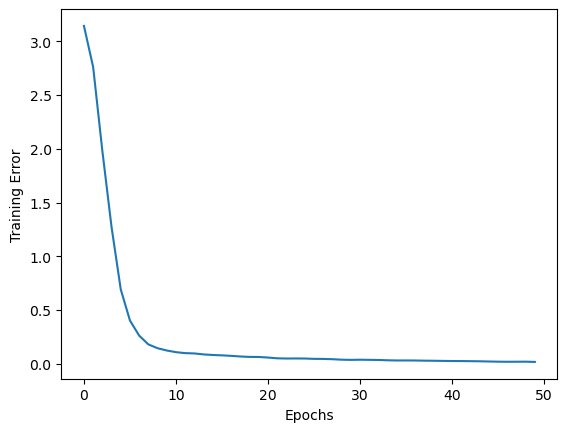

In [206]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

Text(0, 0.5, 'Training Error')

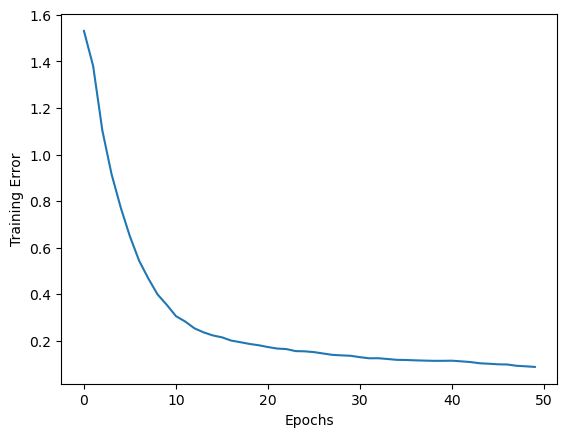

In [222]:
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [207]:
model.evaluate([test.User_id, test.Title], test.Rating)

138/138 [==============================] - 0s 1ms/step - loss: 3.9359 - mean_squared_error: 3.9359 - mean_absolute_error: 1.6567


[3.935892343521118, 3.935892343521118, 1.6567189693450928]

In [221]:
model.evaluate([test.User_id, test.Title], test.Rating)

138/138 [==============================] - 0s 706us/step - loss: 1.7305 - mean_squared_error: 4.4292 - mean_absolute_error: 1.7305


[1.7305138111114502, 4.429156303405762, 1.7305138111114502]

In [186]:
id_place = range(1,20)

# Creating dataset for making recommendations for the first user
tourism_data = np.array(list(set(df.Title)))
tourism_data[:10]

id_user = 3
user = np.array([id_user for i in range(len(tourism_data))])
user[:10]

predictions = model.predict([user, tourism_data])

predictions = np.array([a[0] for a in predictions])

recommended_tourism_ids = (-predictions).argsort()[:10]

recommended_tourism_ids

# print predicted scores
print(predictions[recommended_tourism_ids])

print(recommended_tourism_ids)

307/307 [==============================] - 0s 989us/step
[5.3692064 5.357143  5.304178  5.302675  5.245001  5.216497  5.1655717
 5.164484  5.154902  5.1420674]
[9769 6006 5954 2608 9388 5271 5872  115 2866 5465]


In [217]:
print("10 Recommendation recipe for you")
for i in recommended_tourism_ids:
    print(my_dict[i])

10 Recommendation recipe for you
Telur Dadar Bumbu Urap
Orek-orek telur🍳
Gule kambing super pedes
Ceker Ayam Pedas Manis
Tim Udang Sungai / Gala
Ayam Bakar Taliwang #kisahkasihcookpad
Sayur bayam telor...kesukaan anak kuh...😂😂
Nasi Kebuli Kambing
Tumis Daging Kambing Lada Hitam
Ayam bakar super simpel
